# t-distributed Stochastic Neighbor Embedding (tSNE)
This tutorial shows how to run t-SNE for the deep proprioceptive models 

This script should be run using the libraries from the environment.yml file.

In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue May 14 15:43:21 2019

@author: kai
"""

import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import pickle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
from main import RunInfo
from rowwise_neuron_curves import X_data
from rowwise_neuron_curves import lstring, read_layer_reps

specify which model, run config etc

In [18]:
modelinfo = dict({'type': 'S',
        'typename': 'spatial_temporal',
        'base': 'spatial_temporal_4_8-16-16-32_32-32-64-64_7293',
        'name': 'spatial_temporal_4_8-16-16-32_32-32-64-64_7293_1',
        'base_regression': 'spatial_temporal_r_4_8-16-16-32_32-32-64-64_7293',
        'nlayers': 8,
        'max_nlayers': 8,
        'max_act': 14, #this can be manually adjusted as the maximum in the preferred direction histogram
        'control': False,
        'cmap': matplotlib.colors.ListedColormap(['midnightblue']),
        'color': 'midnightblue',
        'regression_color': 'darkturquoise',
        'control_cmap': 'Greys_r',
        'regression_cmap': matplotlib.colors.ListedColormap(['darkturquoise']),
        's_stride': 2,
        't_stride': 3,
        'regression_task': False,
        'model_path': None,
        'exp_id': None,})

runinfo = RunInfo({'expid': 402, #internal experiment id
                   'datafraction': 'auto',  #fraction (0,1] or 'auto' (i.e. if you want to run a new analysis but keep the old results that it would otherwise overwrite, increment by 1)
                   'randomseed': 2000,
                   'randomseed_traintest': 42,
                   'dirr2threshold': 0.2,
                   'verbose': 2, #0 (least), 1, 2 (most)
                   'model_experiment_id': 22,  #used in model training, int or 'auto'
                   'basefolder': '/media/data/DeepDraw/revisions/analysis-data/', ## change this folder to redirect to where the data is saved locally
                   'batchsize': 100, #for layer representation generation
                   'default_run': True, #only variable that is 'trial'-dependent,
                                    #ie should be changed when rerunning stuff in same folder
                                    #not semantically important for run info
                    'dpi': 500,
                    'orientation': 'hor',
                    'height': 'all',
            })

function declarations

In [19]:
def mytsne(X):
    '''compute tSNE in 2 comps for large datasets: First extract first 50 PCs, then compute tSNE
    
    Arguments
    ---------
    X : np.array [n_samples, n_features]
    
    Returns
    -------
    tsne : sklearn TSNE object
    df : dict containing two tSNE components
    
    '''
    pca = PCA(n_components=50)
    pca_result = pca.fit_transform(X)
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    print(f'Total explained variance: {sum(pca.explained_variance_ratio_)}')

    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(pca_result)
    
    df = dict()
    df['tsne-2d-one'] = tsne_results[:,0]
    df['tsne-2d-two'] = tsne_results[:,1]
    
    return tsne, df

specify options for tSNE run

In [30]:
layer = 7 ### start counting at -1 for spindles

compute tSNE

In [31]:
labels, xyplmvt = X_data('labels', runinfo, datafolder = runinfo.datafolder(modelinfo))

char_labels = ['a', 'b', 'c', 'd', 'e', 'g', 'h', 'l', 'm', 'n',
               'o', 'p', 'q', 'r', 's', 'u', 'v', 'w', 'y', 'z']

lname = "Layer %d" %layer

print(lname)
l = read_layer_reps(layer, runinfo, modelinfo)
l = l[xyplmvt]
        
lx = l.reshape(l.shape[0], -1)

ltsne, ldf = mytsne(lx)

/media/data/DeepDraw/revisions/analysis-data/exp402/data/spatial_temporal_4_8-16-16-32_32-32-64-64_7293/spatial_temporal_4_8-16-16-32_32-32-64-64_7293_1
using alternate method for accessing kinvars files by directly accessing needed arrays (pandas causes error)
1256960
(1964, 2, 320)
Layer 7
read layer represenations. shape:  (4000, 2, 4, 64)
Explained variation per principal component: [0.12948877 0.0979758  0.08780977 0.05181486 0.0456008  0.03803016
 0.03646326 0.03031391 0.02280857 0.02189214 0.02043791 0.01875826
 0.01748635 0.01432715 0.01390052 0.01202889 0.01146703 0.01101084
 0.01021794 0.00916423 0.00896507 0.00806074 0.00763499 0.0068865
 0.00660363 0.00624178 0.00594076 0.0056453  0.00522868 0.00503473
 0.00490407 0.00478815 0.00455517 0.0042772  0.00407608 0.00394958
 0.00355516 0.00349987 0.00335607 0.00321442 0.00316722 0.00305024
 0.00291552 0.00283141 0.00281042 0.00274584 0.00267848 0.00246202
 0.00239706 0.00225059]
Total explained variance: 0.8347239439888304
[t-SNE

plotting options

In [32]:
alpha = 0.8
name = modelinfo['type']

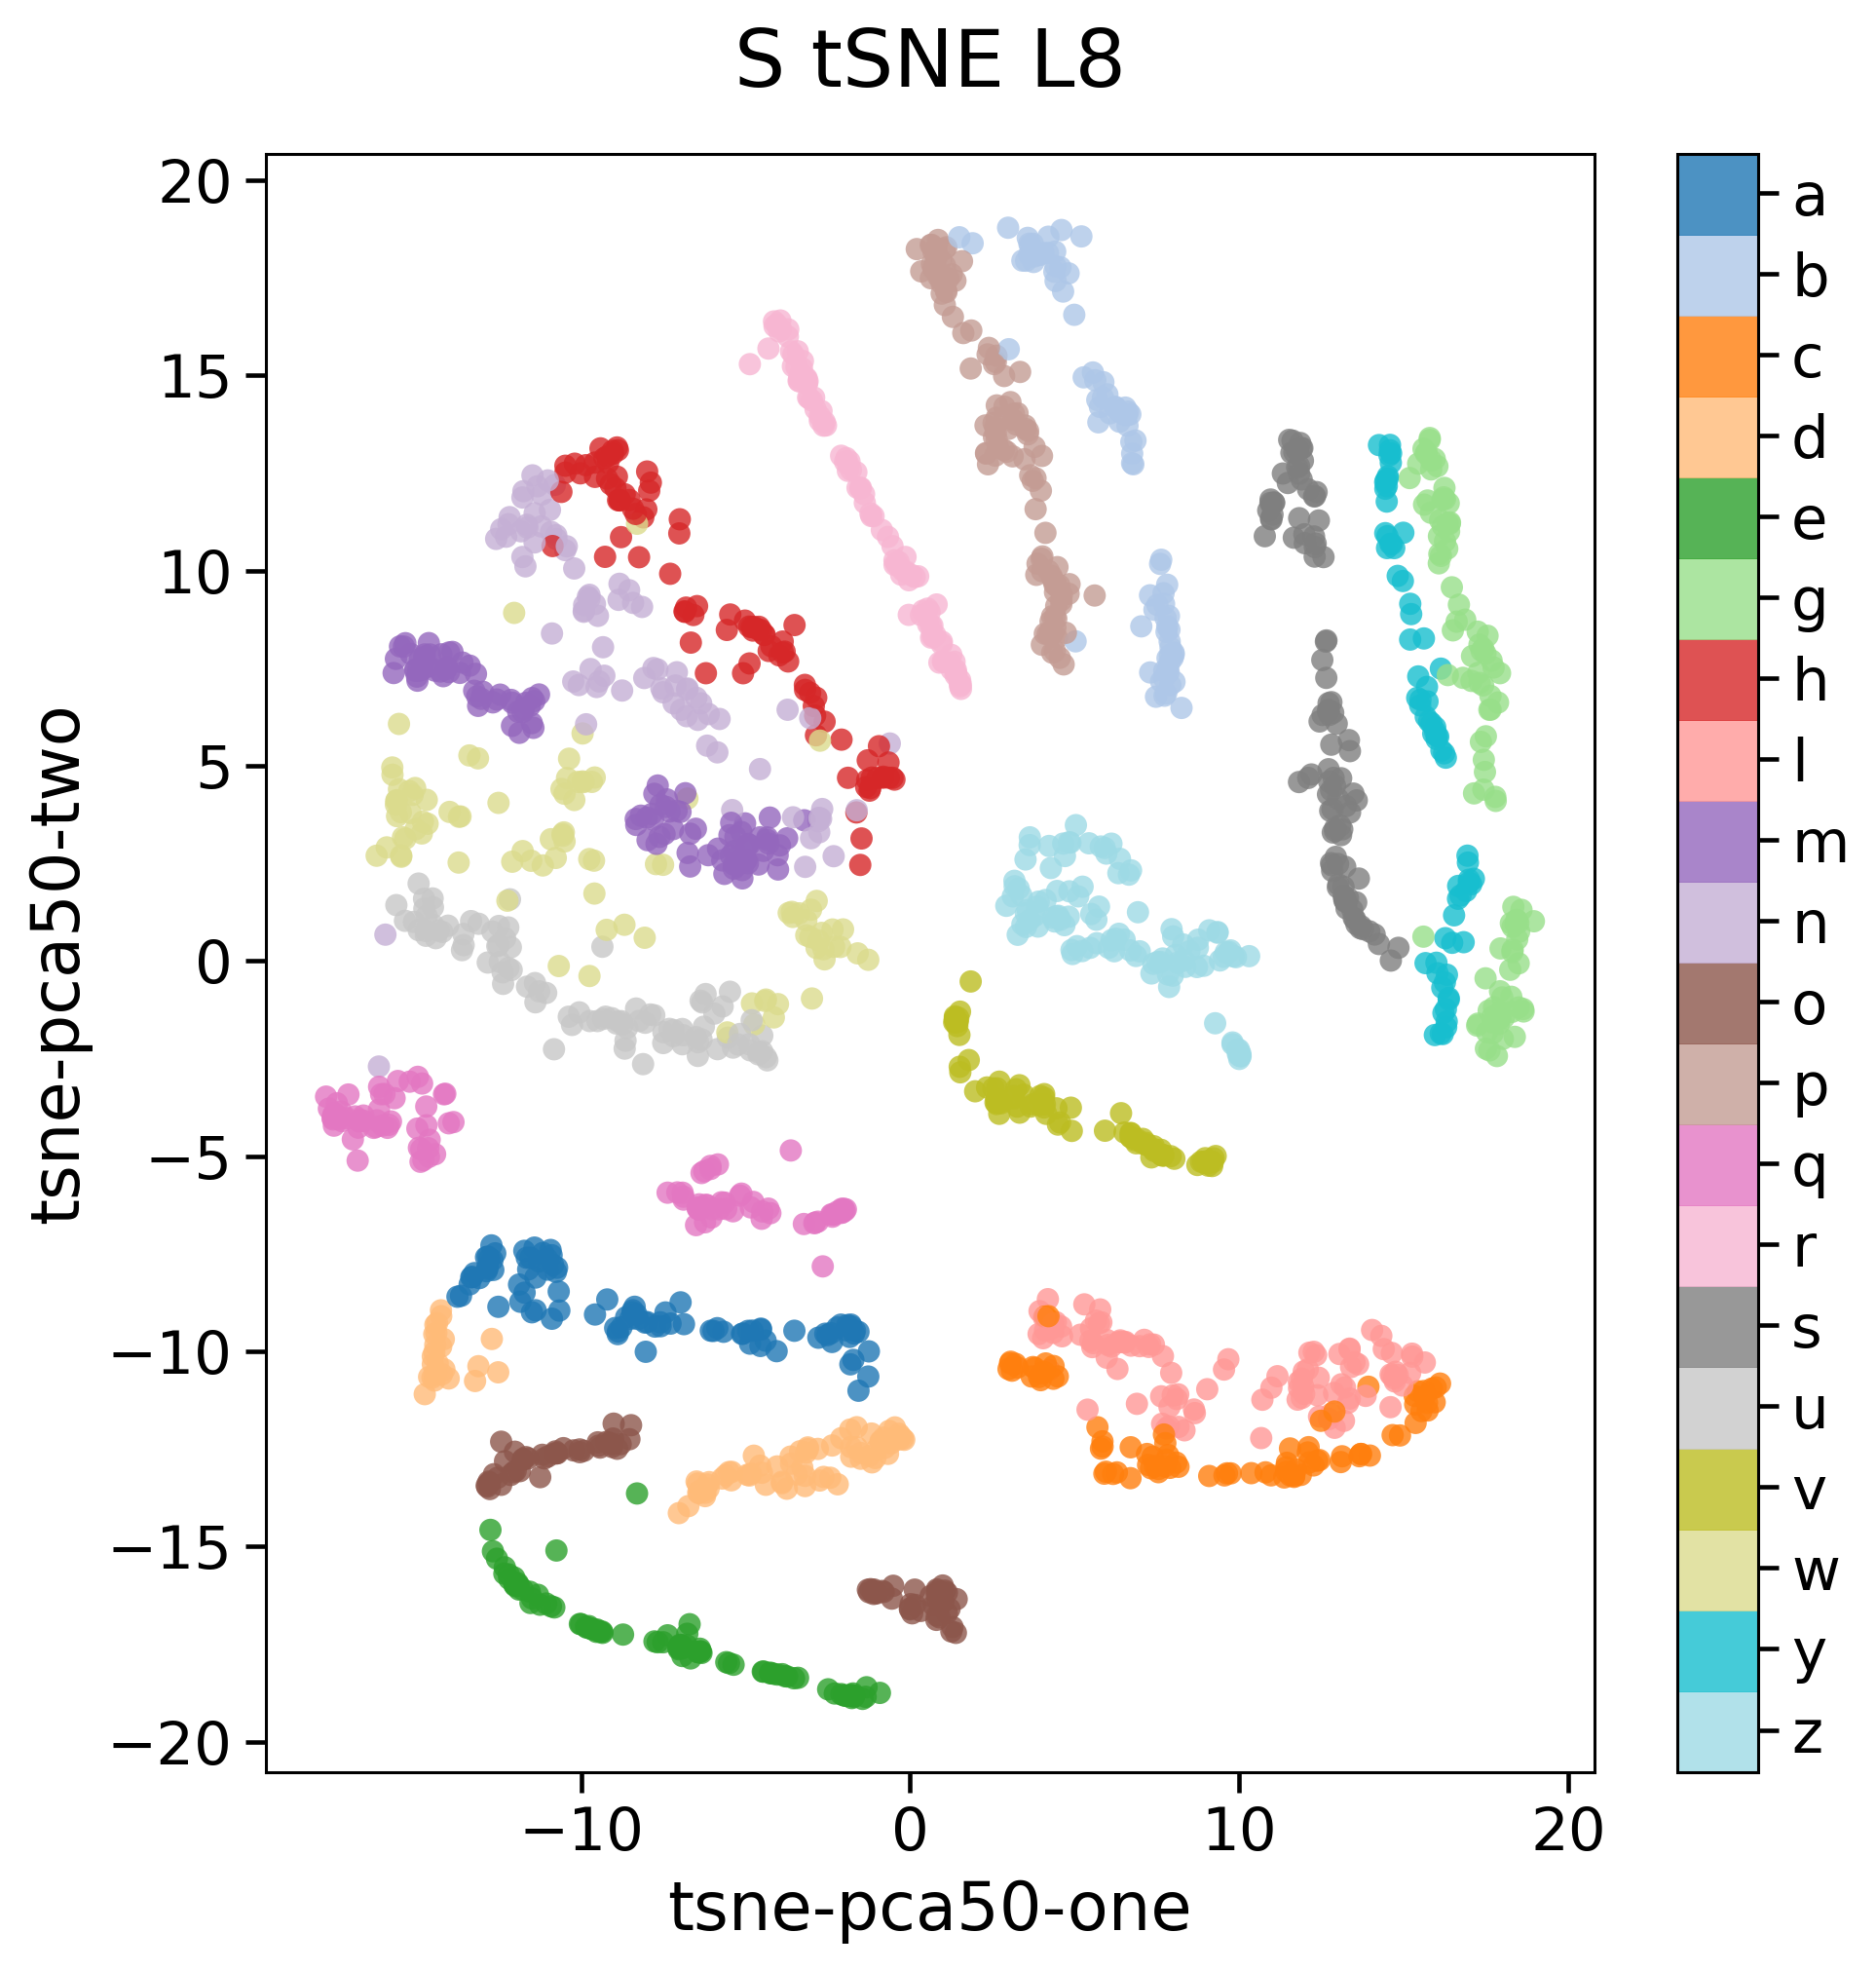

In [33]:
fig = plt.figure(dpi=275)
plt.scatter(
    x = ldf['tsne-2d-one'],
    y = ldf['tsne-2d-two'],
    #s=4,
    edgecolors = 'none',
    c=19 - labels,
    cmap='tab20_r',
    alpha = alpha
)
cb = plt.colorbar()
cb.set_ticks(np.linspace(0.5, 19.5, 21))
cb.set_ticklabels(char_labels[::-1])
plt.title('%s tSNE L%d' %(name, layer + 1))
plt.xlabel('tsne-pca50-one')
plt.ylabel('tsne-pca50-two')
plt.show()
fig